In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d emmarex/plantdisease

100% 655M/658M [00:06<00:00, 124MB/s]
100% 658M/658M [00:06<00:00, 113MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/plantdisease.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
#from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np


In [5]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3


In [6]:
data=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/plantvillage/PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


In [7]:
class_names=data.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [8]:
data


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [9]:
%rm -rf /content/plantvillage/PlantVillage/Pepper__bell___Bacterial_spot
%rm -rf /content/plantvillage/PlantVillage/Pepper__bell___healthy
%rm -rf /content/plantvillage/PlantVillage/Tomato_Bacterial_spot
%rm -rf /content/plantvillage/PlantVillage/Tomato_Early_blight
%rm -rf /content/plantvillage/PlantVillage/Tomato_Late_blight
%rm -rf /content/plantvillage/PlantVillage/Tomato_Leaf_Mold
%rm -rf /content/plantvillage/PlantVillage/Tomato_Septoria_leaf_spot
%rm -rf /content/plantvillage/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite
%rm -rf /content/plantvillage/PlantVillage/Tomato__Target_Spot
%rm -rf /content/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus
%rm -rf /content/plantvillage/PlantVillage/Tomato__Tomato_mosaic_virus
%rm -rf /content/plantvillage/PlantVillage/Tomato_healthy

In [10]:
data=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/plantvillage/PlantVillage",
    #shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [11]:
class_names=data.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [12]:
len(data)

68

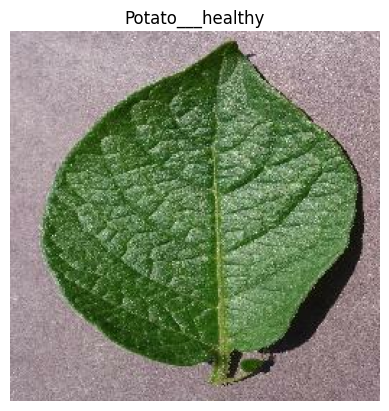

In [13]:
for image_batch,label_batch in data.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")


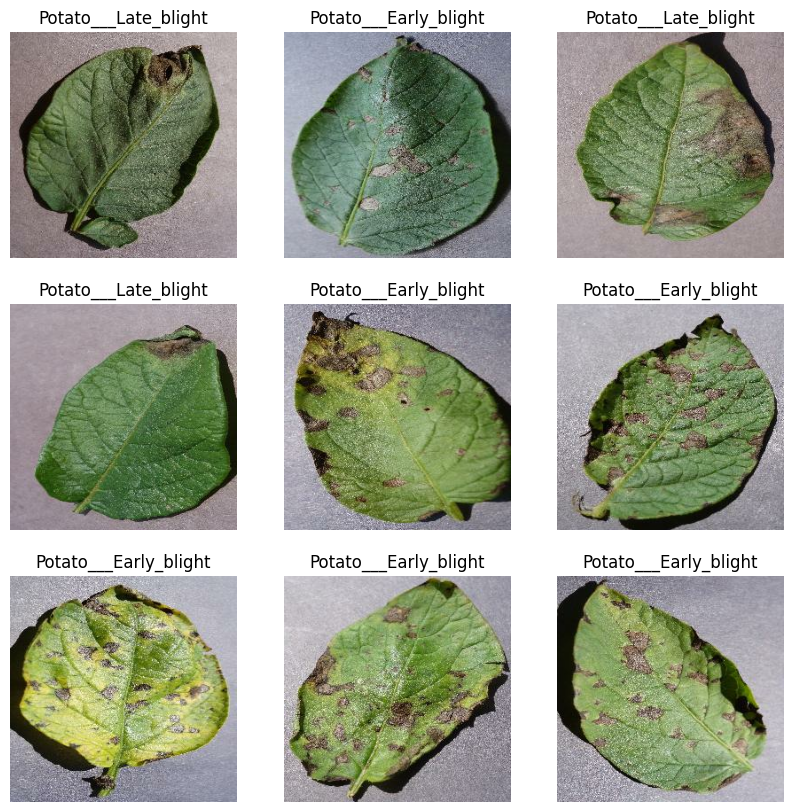

In [14]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in data.take(1):#take 1 takes one batch at once
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [15]:
from sklearn.model_selection import train_test_split

In [ ]:
X = []
y = []
#creating X,y data
for images, labels in data:
    X.append(images.numpy())
    y.append(labels.numpy())

X = np.concatenate(X)
y = np.concatenate(y)

#splitting the data into train and test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)



In [ ]:
#train_size=0.8
#train=data.take(len(data)*train_size)
#trainlen=len(data)*train_size
#trainlen

In [ ]:
#train=data.take(54)

In [ ]:
#test = data.skip(54)
#len(test)
#valsize=0.1
#len(data)*valsize

In [ ]:
#val=test.take(6)
#len(val)

In [ ]:
#test=test.skip(6)
#len(test)

In [ ]:
def split_data(ds, train_size=0.8,val_size=0.1,test_size=0.1,shuffle=True, shuffle_size=1000):
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size,seed=12)

  train_sz=int(train_size*ds_size)
  val_sz=int(val_size*ds_size)

  train = ds.take(train_sz)

  val=ds.skip(train_sz).take(val_sz)
  test=ds.skip(train_sz).skip(val_sz)

  return train,val,test

In [ ]:
train,val,test = split_data(data)

In [ ]:
#optimization for faster training
train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
#rescaling(convert rgb scale into 0, or 1) and resizing(in case the size of image varies)
resize_rescale=tf.keras.Sequential([#creates a sequential model with stacked layers
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)#divides each pixel value by 255 (normalize pixel value to 0,1)

])

In [ ]:
#data augmentation to increase the data,creating 4 new images from each image
data_augmentation=tf.keras.Sequential([
    #flipping the image horizontally and vertically creating two new images
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    #rotating the image creating two more images
    layers.experimental.preprocessing.RandomRotation(0.2)#0.2 means max rotation of 20 degree angle
])

In [27]:
train = train.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [29]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [30]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [31]:
history = model.fit(
    train,
    batch_size=BATCH_SIZE,
    validation_data=val,
    verbose=1,
    epochs=20,
)

Epoch 1/50
54/54 [==============================] - 207s 4s/step - loss: 0.8953 - accuracy: 0.5276 - val_loss: 0.8104 - val_accuracy: 0.5729
Epoch 2/50
54/54 [==============================] - 207s 4s/step - loss: 0.6584 - accuracy: 0.7388 - val_loss: 0.6194 - val_accuracy: 0.7798
Epoch 3/50
54/54 [==============================] - 210s 4s/step - loss: 0.4367 - accuracy: 0.8270 - val_loss: 0.2292 - val_accuracy: 0.9062
Epoch 4/50
54/54 [==============================] - 204s 4s/step - loss: 0.3141 - accuracy: 0.8850 - val_loss: 0.3094 - val_accuracy: 0.9062
Epoch 5/50
54/54 [==============================] - 204s 4s/step - loss: 0.2378 - accuracy: 0.9073 - val_loss: 0.2561 - val_accuracy: 0.8958
Epoch 6/50
54/54 [==============================] - 203s 4s/step - loss: 0.2066 - accuracy: 0.9173 - val_loss: 0.1910 - val_accuracy: 0.9271
Epoch 7/50
21/54 [==========>...................] - ETA: 2:03 - loss: 0.2187 - accuracy: 0.9167

KeyboardInterrupt: 